In [1]:
import gym
import random
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense, Dropout
from keras.optimizers import Adam, SGD
from tqdm import tqdm

Using TensorFlow backend.
/home/david.bertoin/anaconda3/envs/IRT_RL2/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/david.bertoin/anaconda3/envs/IRT_RL2/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Agent

In [2]:
class Agent():
    
    def __init__(self, state_size, action_size, weights=None):
        
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.model = self.build_model()
        self.memory = deque(maxlen=200000)
        self.exploration_rate = 1.0
        self.exploration_min = 0.01
        self.exploration_decay = 0.995
        self.gamma = 0.95
        self.target_model = self.build_model()
        if weights != None:
            self.model.load_weights(weights)
            self.target_model.load_weights(weights)
        
    def build_model(self, learning_rate=0.003):
        model = Sequential()
        model.add(Dense(16, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Dense(16, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Dense(16, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Dense(8, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Dense(self.action_size, activation='linear'))
        model.summary()
        model.compile(loss='mse', optimizer='rmsprop')#Adam(learning_rate))
        
        return model
        
    def next_action(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        actions = self.model.predict(state)[0]
        return np.argmax(actions)
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
                return
        sample_batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in sample_batch:
            target = self.target_model.predict(state)
            if not done:
                target[0][action] = reward + self.gamma * np.amax(self.target_model.predict(next_state)[0])
            else:
                target[0][action] = reward
                self.decay_exploration_rate()
            self.model.fit(state, target, epochs=1, verbose=0)

        
        
    def target_model_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] =  weights[i]
        self.target_model.set_weights(target_weights)
                
    def decay_exploration_rate(self):
        self.exploration_rate = max(self.exploration_min, self.exploration_rate * self.exploration_decay) 
    
    def learn(self, env, nb_episodes, batch_size=64):
        scores = []
        heights = []
        total_rewards = []
        pbar = tqdm(range(nb_episodes))
        for i in pbar:
            state = np.reshape(env.reset(), [1, self.state_size])
            max_height = -1.2
            nb_steps_this_episode = 0
            total_r = 0
            done = False
            
            mx = max_height
            
            while not done:
                action = self.next_action(state)
                next_state, reward, done, _ = env.step(action)
                max_height = max(next_state[0], max_height)
               #if next_state[0] > -0.3:
               #    reward += 1
               #elif next_state[0] > -0.2:
               #    reward += 2
               #elif next_state[0] > -0.1:
               #    reward += 3
               #elif next_state[0] > 0:
               #    reward += 4
               #elif next_state[0] > 0.1:
               #    reward += 5
               #elif next_state[0] > 0.2:
               #    reward += 6
               #elif next_state[0] > 0.4:
               #    reward += 7
               #elif next_state[0] > 0.45:
               #    reward += 200
               
                if max_height > mx:
                    reward = abs(next_state[0] + 0.5)
                    mx = max_height
                #reward += abs(next_state[1])
                if max_height >= 0.5:
                    reward = 100
                   
                total_r += reward
                next_state = np.reshape(next_state, [1, self.state_size])
                self.remember(state, action, reward, next_state, done)
                nb_steps_this_episode += 1
                if done:
                    break
                state = next_state
            total_rewards.append(total_r)
            scores.append(nb_steps_this_episode)
            heights.append(max_height)
            pbar.set_description("episode: %s, nb_steps_this_episode: %s, max height: %s, reward: %s, exploration: %s" \
                                 % (i, scores[i], heights[i], total_rewards[i], self.exploration_rate))
            if (i > 50) and (sum(heights[i-29 : i+1]) / 30 > 0.42):
                break
            self.replay(batch_size)
            self.target_model_train()
        return scores, heights, total_rewards
     

# Environement

In [3]:
env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(state_size, action_size)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 27        
Total params: 755
Trainable params: 755
Non-trainable params: 0
_________________________________________________________________
_____________________________________________

# Training

episode: 1883, nb_steps_this_episode: 124, max height: 0.5224317091469549, reward: 43.6358994837381, exploration: 0.04652918187562211:  38%|███▊      | 1883/5000 [12:14<20:16,  2.56it/s] 

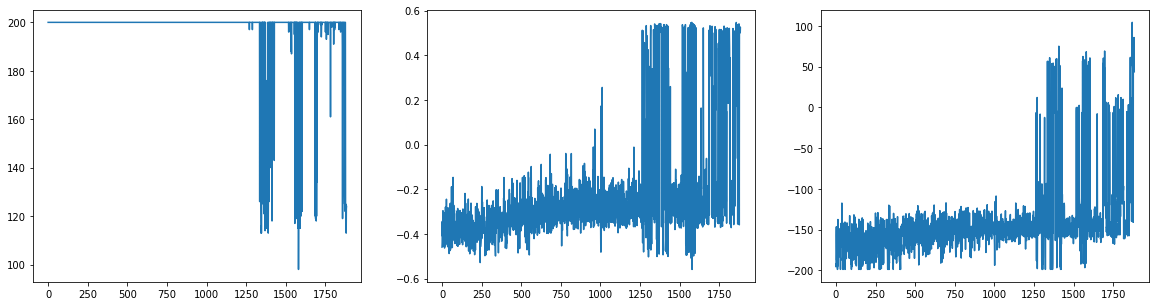

In [4]:
scores, heights, rewards = agent.learn(env, 5000)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(scores)
plt.subplot(1,3,2)
plt.plot(heights)
plt.subplot(1,3,3)
plt.plot(rewards)

# Playing

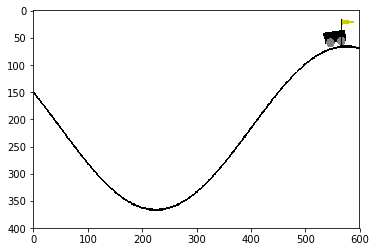

In [5]:
from distant_gym_render import distant_render
distant_render(env, agent, state_size)

# Vizualize decisions

In [6]:
import pandas as pd
X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []
for i in range(len(X)):
    z = np.argmax(agent.model.predict(np.reshape([X[i],Y[i]], [1, 2]))[0])
    Z.append(z)
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

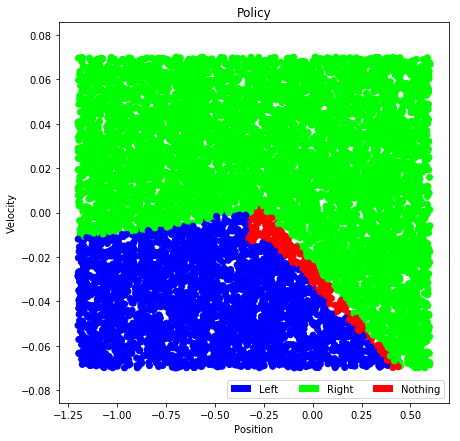

In [7]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
fig.savefig('Policy.png')
plt.show()

# Save weights

In [8]:
agent.model.save_weights("./weights/DQN_montain_model.h5")
agent.target_model.save_weights("./weights/DQN_montain_target_model.h5")